# Predicting Breakpoints with Entropy

This notebook contains the code relevant for assessing the use of entropy as a way of predicting when a breakpoint is, generating the figures present in the entropy-guided search section.

In [1]:
import torch, tqdm, pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json

In [2]:
with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

json_object['val']
val_tasks = []


for file_name in json_object['val']:
    task = Task.from_json(f'../data/training/{file_name}.json')
    val_tasks.append(task )
 

In [3]:
from alphaarc.policy.tokenize import tokenize_task
def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task

## Sensitivity Analysis

In [4]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def compute_entropy(logits): 
    log_p = torch.log_softmax(logits, -1)         
    probs = log_p.exp()                            
    score = -(probs * log_p).sum(-1).squeeze(0)
    return score.detach().cpu()    

# 1 if is 0.0 if not
def in_top_k(logits,               
             target_ids,           
             k):
    topk_idx = logits.topk(k, dim=-1).indices           
    hits     = (topk_idx == target_ids.unsqueeze(-1))   
    return hits.any(-1).float()                         

def gather_val_records(val_tasks, tok, model, top_k):
    model.eval()
    ent_list, err_list = [], []

    for task in val_tasks:
        src_ids = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)
        tgt_ids = tok(task.program_lines,
                      return_tensors="pt").input_ids
        src_ids, tgt_ids = src_ids.to(model.device), tgt_ids.to(model.device)

        with torch.no_grad():
            logits = model(src_ids, labels=tgt_ids).logits   

        score   = compute_entropy(logits) 
        correct = in_top_k(logits, tgt_ids, k=top_k).squeeze(0)  

        ent_list.extend(score.tolist())

        err_list.extend((1.0 - correct).tolist()) # 1 -> error, flips sign
    return ent_list, err_list 



def compute_stats(records, thresh): 
    ent, err = zip(*records)                
    ent = torch.tensor(ent)
    err = torch.tensor(err)                
    pred_err = (ent > thresh)         
    report = classification_report(err, pred_err, target_names=["correct", "error"], output_dict=True)
    
    correct_precision = report['correct']['precision']
    correct_recall= report['correct']['recall']

    error_precision = report['error']['precision']
    error_recall  = report['error']['recall']

    return correct_precision, correct_recall, error_precision, error_recall





thresholds = [0.1, 0.2, 0.5, 1, 2, 4, 8]
top_k = [1, 2, 4,8]
pairs = list(itertools.product(thresholds, top_k))


correct_precisions = []
correct_recalls = []
error_precisions = []
error_recalls = []


tok = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
model = T5ForConditionalGeneration.from_pretrained( '../finetune/2025-06-16_01-31-36/checkpoint-80')

for pair in pairs:
    thresh, k = pair
    entropy, is_err = gather_val_records(val_tasks, tok, model, top_k=k)
    cp, cr, ep, er = compute_stats(list(zip(entropy, is_err)), thresh=thresh)

    correct_precisions.append(cp)
    correct_recalls.append(cr)
    error_precisions.append(ep)
    error_recalls.append(er)


    

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
/home/mgws3/.conda/envs/AlphaARC/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mgws3/.conda/envs/AlphaARC/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

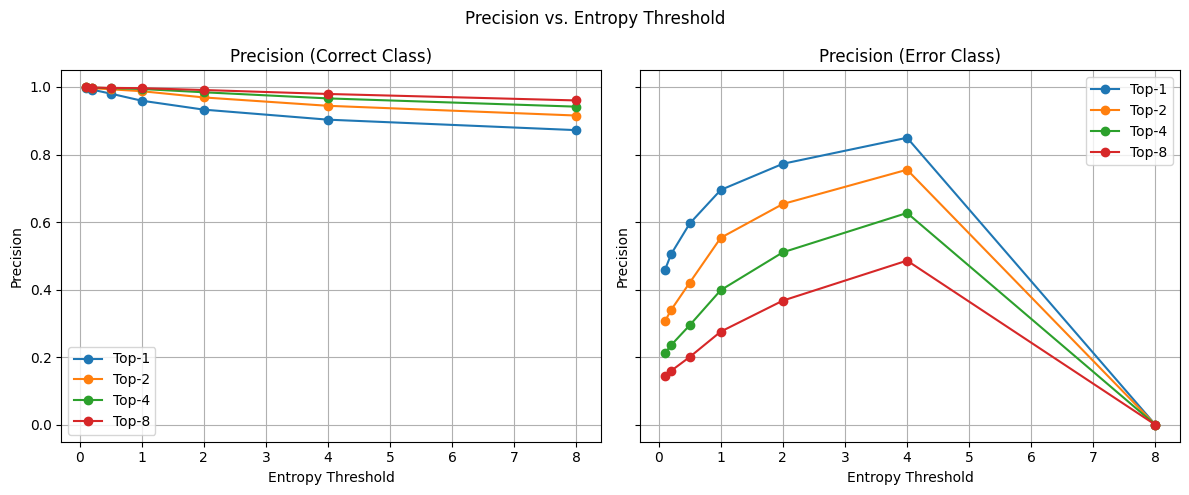

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


thresholds_list, top_k_list = zip(*pairs)

df = pd.DataFrame({
    'threshold': thresholds_list,
    'top_k': top_k_list,
    'precision_correct': correct_precisions,
    'recall_correct': correct_recalls,
    'precision_error': error_precisions,
    'recall_error': error_recalls
})

top_k_values = sorted(set(top_k_list))
threshold_values = sorted(set(thresholds_list))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for k in top_k_values:
    df_k = df[df['top_k'] == k]
    axs[0].plot(df_k['threshold'], df_k['precision_correct'], marker='o', label=f"Top-{k}")
    axs[1].plot(df_k['threshold'], df_k['precision_error'], marker='o', label=f"Top-{k}")

axs[0].set_title("Precision (Correct Class)")
axs[1].set_title("Precision (Error Class)")
for ax in axs:
    ax.set_xlabel("Entropy Threshold")
    ax.set_ylabel("Precision")
    ax.grid(True)
    ax.legend()

plt.suptitle("Precision vs. Entropy Threshold")
plt.tight_layout()
plt.show()

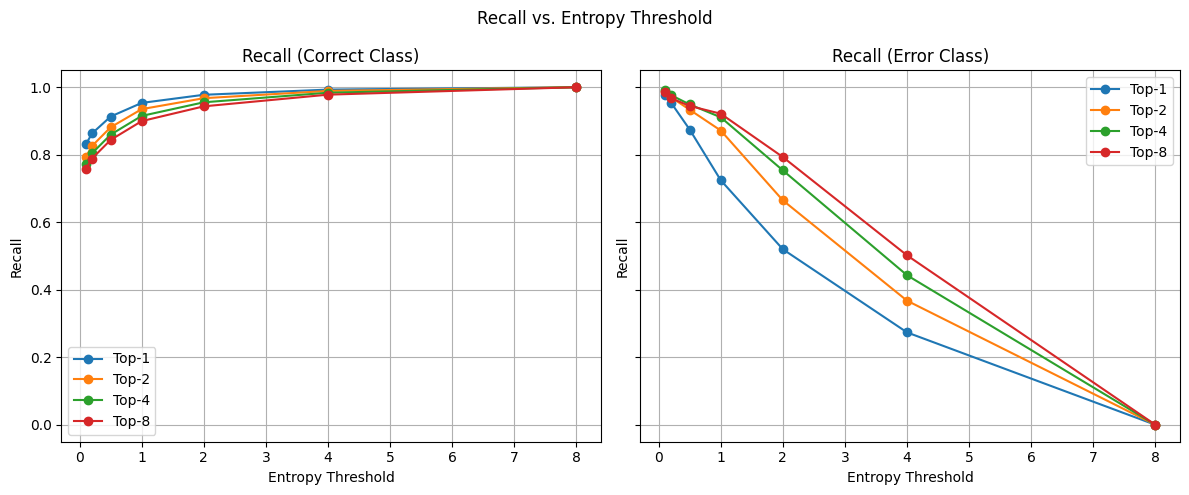

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for k in top_k_values:
    df_k = df[df['top_k'] == k]
    axs[0].plot(df_k['threshold'], df_k['recall_correct'], marker='o', label=f"Top-{k}")
    axs[1].plot(df_k['threshold'], df_k['recall_error'], marker='o', label=f"Top-{k}")

axs[0].set_title("Recall (Correct Class)")
axs[1].set_title("Recall (Error Class)")
for ax in axs:
    ax.set_xlabel("Entropy Threshold")
    ax.set_ylabel("Recall")
    ax.grid(True)
    ax.legend()

plt.suptitle("Recall vs. Entropy Threshold")
plt.tight_layout()
plt.show()

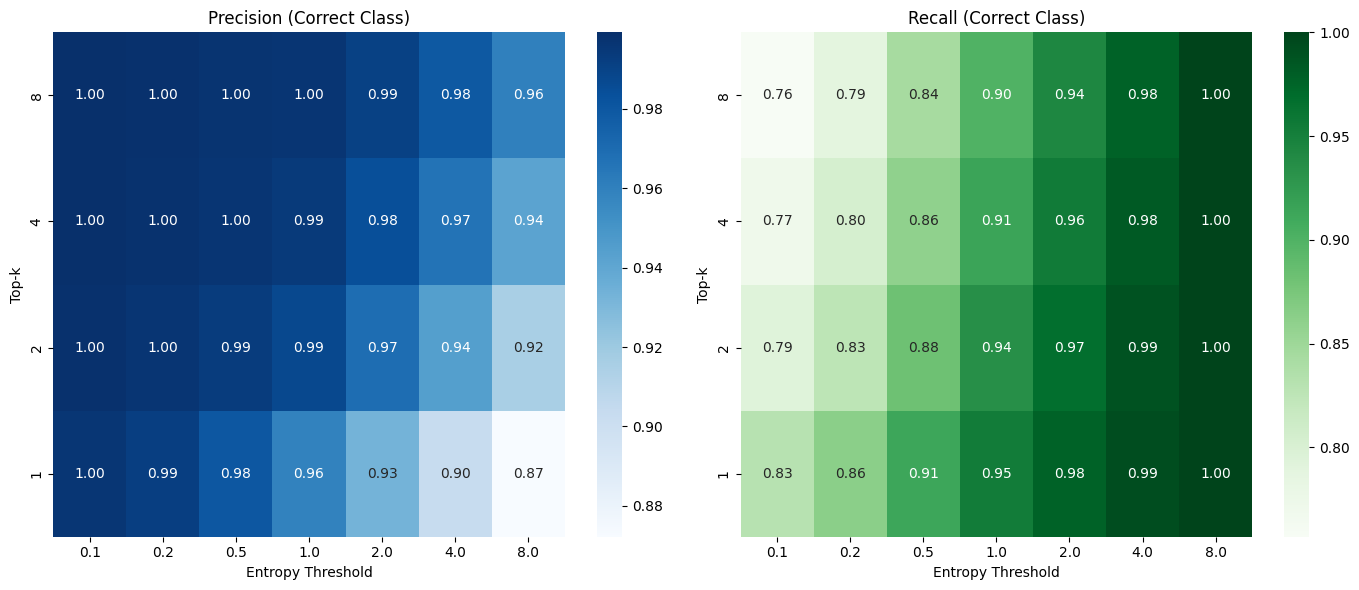

In [7]:
import seaborn as sns
# Pivot tables for correct class
precision_pivot_correct = df.pivot(index='top_k', columns='threshold', values='precision_correct')
recall_pivot_correct = df.pivot(index='top_k', columns='threshold', values='recall_correct')

# Sort the index in descending order (top_k: 8 → 1)
precision_pivot_correct_sorted = precision_pivot_correct.sort_index(ascending=False)
recall_pivot_correct_sorted = recall_pivot_correct.sort_index(ascending=False)

# Plot heatmaps with reversed top-k order
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(precision_pivot_correct_sorted, annot=True, fmt=".2f", cmap="Blues", ax=axs[0])
axs[0].set_title("Precision (Correct Class)")
axs[0].set_xlabel("Entropy Threshold")
axs[0].set_ylabel("Top-k")

sns.heatmap(recall_pivot_correct_sorted, annot=True, fmt=".2f", cmap="Greens", ax=axs[1])
axs[1].set_title("Recall (Correct Class)")
axs[1].set_xlabel("Entropy Threshold")
axs[1].set_ylabel("Top-k")

plt.tight_layout()
plt.show()

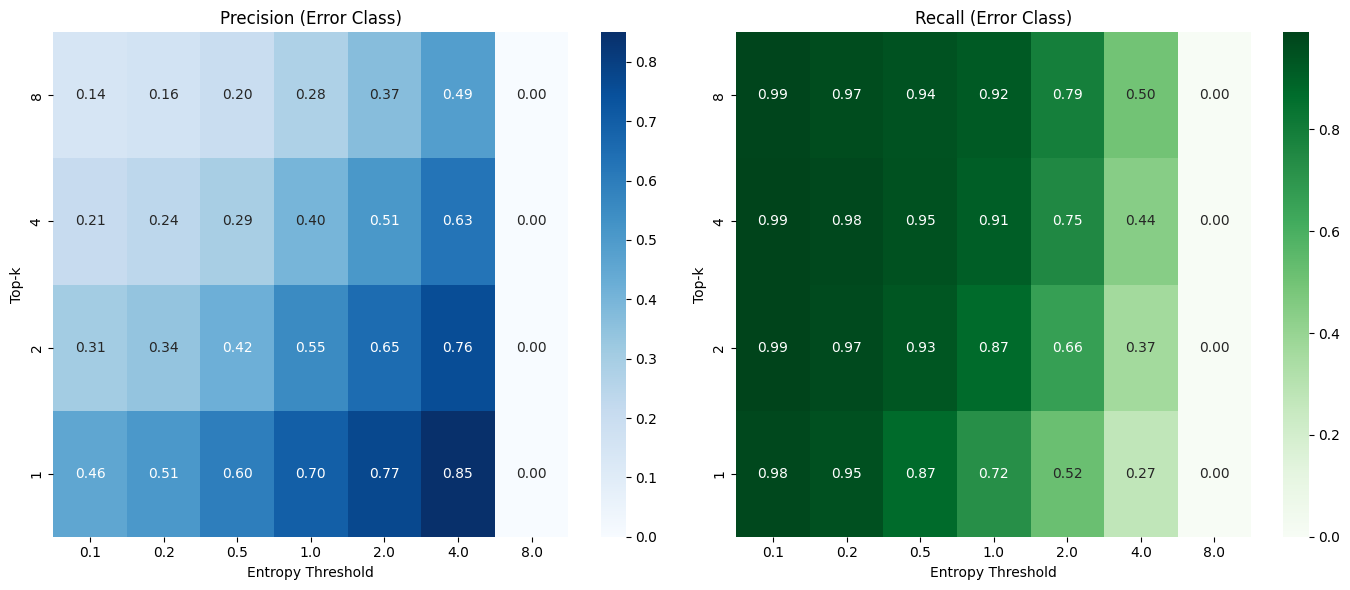

In [8]:
import seaborn as sns
# Pivot tables for correct class
precision_pivot_correct = df.pivot(index='top_k', columns='threshold', values='precision_error')
recall_pivot_correct = df.pivot(index='top_k', columns='threshold', values='recall_error')

# Sort the index in descending order (top_k: 8 → 1)
precision_pivot_correct_sorted = precision_pivot_correct.sort_index(ascending=False)
recall_pivot_correct_sorted = recall_pivot_correct.sort_index(ascending=False)

# Plot heatmaps with reversed top-k order
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(precision_pivot_correct_sorted, annot=True, fmt=".2f", cmap="Blues", ax=axs[0])
axs[0].set_title("Precision (Error Class)")
axs[0].set_xlabel("Entropy Threshold")
axs[0].set_ylabel("Top-k")

sns.heatmap(recall_pivot_correct_sorted, annot=True, fmt=".2f", cmap="Greens", ax=axs[1])
axs[1].set_title("Recall (Error Class)")
axs[1].set_xlabel("Entropy Threshold")
axs[1].set_ylabel("Top-k")

plt.tight_layout()
plt.show()

## Illustrative Example

=== Task c8f0f002 Program ===
O = replace(I, SEVEN, FIVE)
[0.008326766081154346, 0.29708588123321533, 0.001772076589986682, 4.66688871383667, 0.0008075899095274508, 0.002142125042155385, 0.0003796852251980454, 2.06357479095459, 0.011276112869381905, 0.006272976286709309, 0.00042854761704802513, 1.0860165357589722, 0.004817784298211336, 0.0007430999539792538, 0.0025732170324772596]


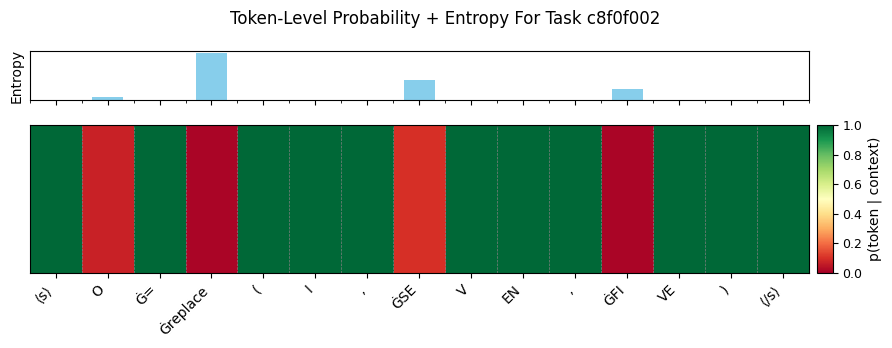

In [9]:
from alphaarc.policy.tokenize import tokenize_task

def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task


def output_program_lines(task):
    print(f"=== Task {task.task_key} Program ===")

    print(task.program_lines)


def compute_logits(task, model, ): 
    tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
    target_text = task.program_lines
    model.eval()

    input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

    ids      = tok(target_text, return_tensors="pt").input_ids

    with torch.no_grad():
        logits = model(input_, labels =ids).logits        
    
    log_p     = torch.log_softmax(logits, -1)
    p = torch.exp(log_p)

    entropy = -(p * log_p).sum(dim=-1).squeeze()
    entropy = entropy.tolist()    
    print(entropy)
    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)  
    p_token    = token_logp.exp().squeeze().tolist()            
    tokens     = tok.convert_ids_to_tokens(ids[0])

    return tokens, p_token, entropy


 
def output_correct_token_probs(task_id, tokens, p_token, entropy):
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(len(tokens) * 0.6, 3.5),
        gridspec_kw={"height_ratios": [1, 3]},
        sharex=True
    )

    ax1.bar(
        np.arange(len(entropy)),
        entropy,
        width=0.6,
        color='skyblue',
        align='center'
    )
    ax1.set_ylabel("Entropy", fontsize=10)
    ax1.set_yticks([])  # optional

    im = ax2.imshow(
        np.array([p_token]),
        aspect="auto",
        cmap="RdYlGn",
        vmin=0,
        vmax=1,
        extent=[-0.5, len(tokens) - 0.5, 0, 1]   
    )

    display_tokens = [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens]

    ax2.set_yticks([])
    ax2.set_xticks(range(len(tokens)))
    ax2.set_xticklabels(display_tokens, rotation=45, ha="right", fontsize=10)

    # Add minor grid lines between tokens
    ax2.set_xticks(np.arange(-.5, len(tokens), 1), minor=True)
    ax2.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    ax2.tick_params(axis='x', which='minor', bottom=False)

    # Colorbar
    cax = ax2.inset_axes([1.01, 0, 0.02, 1])  # [left, bottom, width, height] in axis fraction
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("p(token | context)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)    
    cbar.set_label("p(token | context)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    plt.suptitle(f"Token-Level Probability + Entropy For Task {task_id}", fontsize=12)
    plt.tight_layout()
    plt.show()



def generate_task_level_analysis(task, model_path= '../finetune/2025-06-16_01-31-36/checkpoint-80'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    output_program_lines(task)
    tokens, p_token, entropy = compute_logits(task, model)
    output_correct_token_probs(task.task_key, tokens, p_token, entropy)


    
# change here the task and model you wish to use.
task = val_tasks[1 ]
generate_task_level_analysis(task, model_path= '../finetune/2025-06-16_01-31-36/checkpoint-80')